# Construction of sparse basis via Leaf Removal
-----------------
**Idea**: given a parity-check matrix $H\in\mathbb{GF}(2)^{m,n}$ and its corresponding factor graph,
- Use Leaf Removal to separate variables into a set of $m$ dependent and $n-m$ independent ones $$H = [T|M]$$
- Build a basis by setting, for each basis vector $\underline{v}^{(i)}$:
    - For the independent variables, put a $1$ in position $i$ and all the rest zeros $$v_{indep}^{(i)}=\mathbb{1}_{i}\quad$$
    - Fix the dependent variables (uniquely determined from the independent part)
<!--     $$\underline{v}_{dep}^{(i)}=f\left(\{\underline{v}_{indep}^{(i)}\}\right)$$ -->
        $$\underline{v}_{dep} = T^{-1}M$$
    
**Goal**: Is this basis sparse? What is the maximum Hamming weight between all basis vectors?

## 1. Check that the built basis actually solves the system

In [1]:
include("../code/headers.jl");

Build a random graph (with leaves!)

In [2]:
seed = abs(rand(Int))
const q = 2
n = 20
m = 15
fg = ldpc_graph(q, n, m, randseed=seed)
breduction!(fg);

Compute the basis

In [3]:
nb = newbasis(fg)

20×6 Array{Int64,2}:
 0  0  0  0  1  1
 1  0  0  0  0  0
 0  1  0  0  0  0
 1  0  0  0  0  0
 0  0  1  0  1  0
 1  1  1  0  0  0
 0  0  1  0  0  0
 1  1  1  0  0  1
 0  0  0  1  0  0
 0  0  0  0  1  0
 0  0  0  0  0  1
 1  0  0  0  1  1
 0  1  1  1  1  0
 0  1  1  0  0  0
 0  0  0  0  0  1
 0  0  0  1  0  0
 0  0  1  0  0  0
 1  0  0  1  1  1
 0  1  1  0  1  0
 0  0  0  0  0  1

Check that parity is satisfied by all of the basis vectors

In [4]:
parity(fg, nb)

0

## 2. Build large instances and observe sparsity

In [5]:
function sparsity(A::Array{Int,2})
    nnonzeros = sum(A.!=0)
    nentries = length(A)
    return nnonzeros/nentries
end
function max_hw(A::Array{Int,2})
    (n,k) = size(A)
    hws = [hw(A[:,c]) for c in 1:k]
    return maximum(hws)
end
function sparsity_and_hw(q, n, m, seed)
    fg = ldpc_graph(q,n,m, randseed=seed)
    breduction!(fg, randseed=seed)
    nb = newbasis(fg)
    return max_hw(nb), sparsity(nb)
end

sparsity_and_hw (generic function with 1 method)

In [6]:
ngraphs = 20
n = 500
R = 0.3
m = Int(round(n*(1-R)))
max_hws_ = zeros(ngraphs)
sparsities_ = zeros(ngraphs);

In [7]:
for g in 1:ngraphs
    max_hws_[g], sparsities_[g] = sparsity_and_hw(q, n, m, seed+g)
end

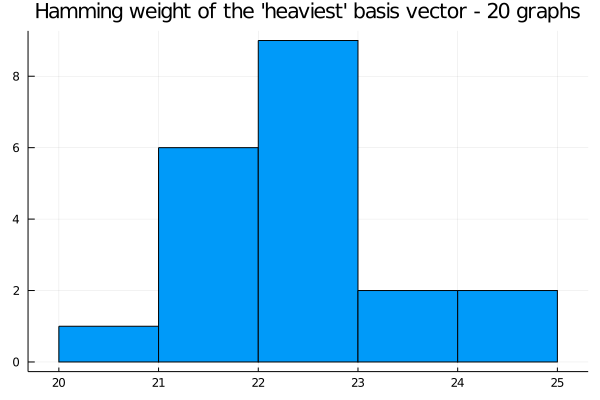

In [8]:
Plots.histogram(max_hws_, label="")
title!("Hamming weight of the 'heaviest' basis vector - $ngraphs graphs")

## 3. Monitor maximum Hamming weight for increasing size

In [18]:
ngraphs = 20
nn = 2 .^ (4:16)
nsizes = length(nn)
R = 0.3
max_hws = zeros(nsizes, ngraphs)
sparsities = zeros(nsizes, ngraphs);

In [19]:
for (i,n) in enumerate(nn)
    println("n=$n. Size $i of $nsizes")
    m = Int(round(n*(1-R)))
    @showprogress for g in 1:ngraphs
        max_hws[i,g], sparsities[i,g] = sparsity_and_hw(q, n, m, seed+g)
    end
end

n=16. Size 1 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


n=32. Size 2 of 13
n=64. Size 3 of 13
n=128. Size 4 of 13
n=256. Size 5 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


n=512. Size 6 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


n=1024. Size 7 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


n=2048. Size 8 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


n=4096. Size 9 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


n=8192. Size 10 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


n=16384. Size 11 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:05:09


n=32768. Size 12 of 13


Progress: 100%|█████████████████████████████████████████| Time: 0:36:45


n=65536. Size 13 of 13


Progress: 100%|█████████████████████████████████████████| Time: 2:27:28


### Plot the average maximum HW as n increases

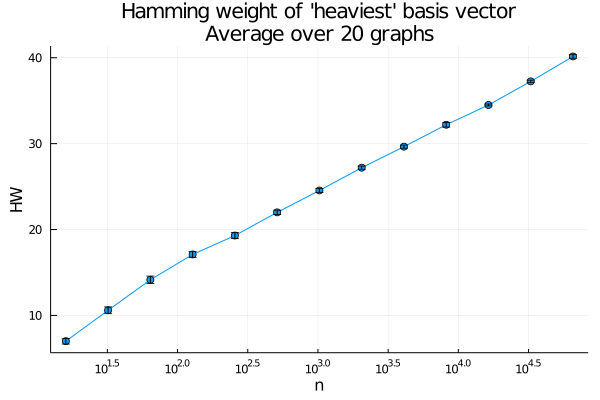

In [20]:
# labels = hcat(["n="*string(n) for n in nn]...)
# histogram(permutedims(max_hws), layout=(ceil(Int, nsizes/3),3), label=labels, size=(800,400))

avg_max_hw = mean(max_hws, dims=2)
sd_max_hw = std(max_hws, dims=2) / sqrt(ngraphs)
Plots.plot(nn, avg_max_hw, yerr=sd_max_hw, marker=:circle, label="", xscale=:log10)
Plots.xlabel!("n"); Plots.ylabel!("HW"); 
Plots.title!("Hamming weight of 'heaviest' basis vector\nAverage over $(size(max_hws,2)) graphs")

## 4. Computational time

In [15]:
using BenchmarkTools
BenchmarkTools.DEFAULT_PARAMETERS.seconds = 30
include("../code/headers.jl");

In [16]:
nn = 100:100:2000
nsizes = length(nn)
R = 0.3
runtimes = zeros(nsizes)
println("-- This will take approx $(BenchmarkTools.DEFAULT_PARAMETERS.seconds*nsizes) seconds")
for (i,n) in enumerate(nn)
    println("n=$n. Size $i of $nsizes")
    m = Int(round(n*(1-R)))
    fg =ldpc_graph(q,n,m, randseed=seed+i)
    breduction!(fg, randseed=seed)
    H,c = permute_to_triangular(fg)
    runtimes[i] = @belapsed newbasis($H, $c)
end

-- This will take approx 600.0 seconds
n=100. Size 1 of 20
n=400. Size 4 of 20
n=500. Size 5 of 20
n=600. Size 6 of 20
n=700. Size 7 of 20
n=800. Size 8 of 20
n=900. Size 9 of 20
n=1000. Size 10 of 20
n=1100. Size 11 of 20
n=1200. Size 12 of 20
n=1300. Size 13 of 20
n=1400. Size 14 of 20
n=1500. Size 15 of 20
n=1600. Size 16 of 20
n=1700. Size 17 of 20
n=1800. Size 18 of 20
n=1900. Size 19 of 20
n=2000. Size 20 of 20


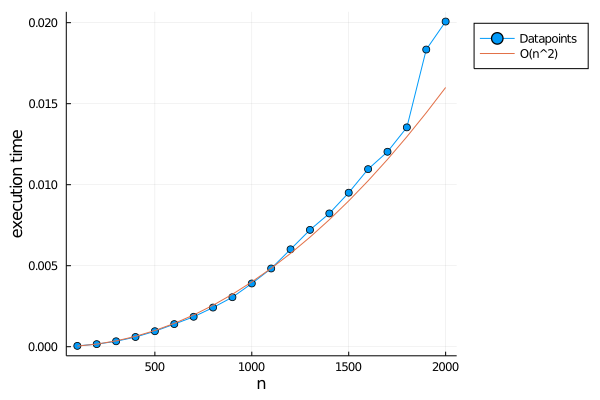

In [17]:
plot(nn, runtimes, xlabel="n", ylabel="execution time", marker=:circle, label="Datapoints", legend = :outertopright)
k = 2
plot!(nn, nn.^k .* 4e-9, label="O(n^$k)")